In [1]:
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from Solver import nummodel, nummodel_jac, explicit_solve, implicit_solve
from NeuralNet import *
from timeit import default_timer



In [2]:
def permeability_ref(q, dq):
    return q**2 + dq**2 + 1
def D_permeability_ref(q, dq):
    return 2*q, 2*dq


# Training a quadratic function
 $$D(\theta) = \theta^2 + (\frac{\partial \theta}{\partial x})^2 + 1$$

In [7]:
nn_save_name = "quadratic.nn"
N_train_1d = 100
L_train_1d = 1
N_train = N_train_1d**2

x_train_1d = np.linspace(-L_train_1d, L_train_1d, N_train_1d)
X_train_2d, Y_train_2d = np.meshgrid(x_train_1d, x_train_1d)


x_train = np.vstack((X_train_2d.reshape(-1), Y_train_2d.reshape(-1))).T
y_train = permeability_ref(x_train[:, 0], x_train[:, 1]).reshape((N_train, 1))
    
x_train = torch.from_numpy(x_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))

ind = x_train.shape[1]
outd = y_train.shape[1] 

learning_rate = 0.001
step_size = 100
gamma = 0.5  
epochs = 2000
batch_size = 64

layers = 2
width  = 20
nn_model = FNN(ind, outd, layers, width) 

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

optimizer = Adam(nn_model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = torch.nn.MSELoss(reduction='sum')
t0 = default_timer()
for ep in range(epochs):
    nn_model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:

        optimizer.zero_grad()
        out = nn_model(x)
        
        loss = myloss(out , y)*100
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    if ep % 100 == 0:
        # train_l2/= ntrain
        t2 = default_timer()
        print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
    if nn_save_name is not None:
        torch.save(nn_model, nn_save_name)
        


Epoch :  0  Epoch time :  0.13543719700000167  Train L2 Loss :  2504189.156982422
Epoch :  100  Epoch time :  0.1311959690000002  Train L2 Loss :  192.59070409834385
Epoch :  200  Epoch time :  0.12748534199999995  Train L2 Loss :  111.00582671165466
Epoch :  300  Epoch time :  0.10555172299999782  Train L2 Loss :  97.88013371825218
Epoch :  400  Epoch time :  0.12203464399999575  Train L2 Loss :  94.83074733614922
Epoch :  500  Epoch time :  0.1111831829999943  Train L2 Loss :  90.38377943634987
Epoch :  600  Epoch time :  0.11446948799999745  Train L2 Loss :  88.15462496876717
Epoch :  700  Epoch time :  0.11522043799999437  Train L2 Loss :  87.248336404562
Epoch :  800  Epoch time :  0.12449593899999911  Train L2 Loss :  86.79639934003353
Epoch :  900  Epoch time :  0.11244528399998899  Train L2 Loss :  86.60866455733776
Epoch :  1000  Epoch time :  0.10920211800001312  Train L2 Loss :  86.47435019910336
Epoch :  1100  Epoch time :  0.1323449109999899  Train L2 Loss :  86.4243338704

# Testing on the quadratic function

In [8]:
N_test_1d = 200
L_test_1d = 1
N_test = N_test_1d**2

x_test_1d = np.linspace(-L_test_1d, L_test_1d, N_test_1d)
X_test_2d, Y_test_2d = np.meshgrid(x_test_1d, x_test_1d)

x_test = np.vstack((X_test_2d.reshape(-1), Y_test_2d.reshape(-1))).T    
y_test = permeability_ref(x_test[:, 0], x_test[:, 1]).reshape((N_test, 1))



x_test = torch.from_numpy(x_test.astype(np.float32))
y_pred = nn_model(x_test).detach().numpy()



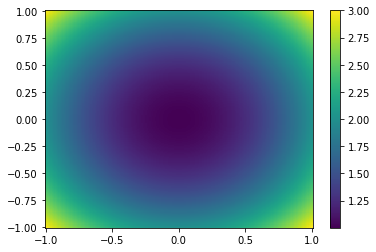

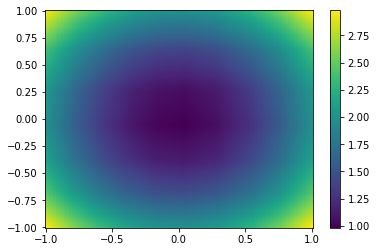

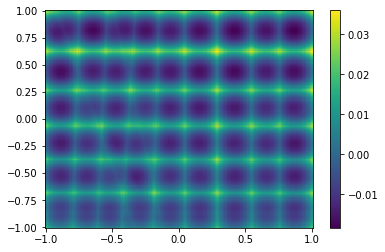

In [9]:
y_test_2d = y_test.reshape((N_test_1d,N_test_1d))
y_pred_2d = y_pred.reshape((N_test_1d,N_test_1d))

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d)
plt.colorbar()

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_pred_2d)
plt.colorbar()

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d - y_pred_2d)
plt.colorbar()

# Derivative test

In [10]:
q = np.array([1.0])
dq = np.array([1.0])
x = torch.from_numpy((np.vstack((q, dq)).T).astype(np.float32))  
x.requires_grad = True
y = nn_model(x)  #.detach().numpy().flatten()

d = torch.autograd.grad(y, x)

print("analytical derivative is :", d)
eps = 1e-3
xp0 = x + torch.Tensor([eps, 0.0])
yp0 = nn_model(xp0)
xp1 = x + torch.Tensor([0.0, eps])
yp1 = nn_model(xp1)

print("FD derivative is :", (yp0-y)/eps, (yp1-y)/eps)


analytical derivative is : (tensor([[1.7296, 1.6361]]),)
FD derivative is : tensor([[1.7300]], grad_fn=<DivBackward0>) tensor([[1.6360]], grad_fn=<DivBackward0>)


# Plug-in test

1 max q:  0.005554848384769776  L2 res:  42.60868807004445
2 max q:  0.010430324793802723  L2 res:  37.131636066051705
3 max q:  0.01484799353275517  L2 res:  34.65145233940013
4 max q:  0.01893730562603508  L2 res:  32.90649420338676
5 max q:  0.022766409463092913  L2 res:  31.535081803495398
6 max q:  0.026377902612237672  L2 res:  30.395459951652683
7 max q:  0.029799375356517575  L2 res:  29.442182647326472
8 max q:  0.0330476812160392  L2 res:  28.587384932856807
9 max q:  0.03617136389844119  L2 res:  27.8235894207724
10 max q:  0.039175225105584945  L2 res:  27.154054735105575
11 max q:  0.042046097532808115  L2 res:  26.54435764273271
12 max q:  0.04486158151063552  L2 res:  25.9872765148144
13 max q:  0.047555917354842075  L2 res:  25.474917257256894
14 max q:  0.050200906687230956  L2 res:  24.995921421781315
15 max q:  0.05275359253351942  L2 res:  24.552366531128822
16 max q:  0.05526440458209395  L2 res:  24.132248137873546
17 max q:  0.05770022762970133  L2 res:  23.74206

148 max q:  0.23377223199334443  L2 res:  2.30612776322485
149 max q:  0.2341263175463893  L2 res:  2.2568136604746467
150 max q:  0.23447283163774194  L2 res:  2.208503732225665
151 max q:  0.23481191895221556  L2 res:  2.161135548349411
152 max q:  0.23514372559430652  L2 res:  2.114747240010872
153 max q:  0.23546839822733187  L2 res:  2.069318763035586
154 max q:  0.23578608232720763  L2 res:  2.024821059042786
155 max q:  0.23609692200558252  L2 res:  1.9812031492947457
156 max q:  0.2364010595624431  L2 res:  1.938542121541502
157 max q:  0.2366986352184079  L2 res:  1.8967683857564903
158 max q:  0.23698978689014677  L2 res:  1.855865143838912
159 max q:  0.23727465013481513  L2 res:  1.8158160339381098
160 max q:  0.23755335736572353  L2 res:  1.7766041552270553
161 max q:  0.23782603879049632  L2 res:  1.7382124284896752
162 max q:  0.23809282134465895  L2 res:  1.7007186049222192
163 max q:  0.23835382916043213  L2 res:  1.6636864271407978
164 max q:  0.23860918375415605  L2 

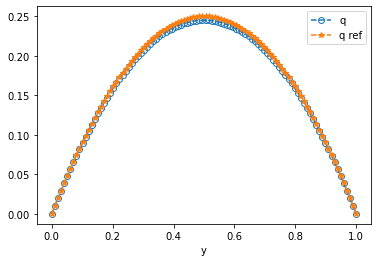

In [20]:
def permeability(q, dq):
    
    x = np.vstack((q, dq)).T
    
    permeability = nn_model(torch.from_numpy(x.astype(np.float32))).detach().numpy().flatten()
    
    return permeability

def D_permeability(q, dq):
    
    Ny = q.size
    Dq, Ddq = np.zeros(Ny), np.zeros(Ny)
    
    for i in range(Ny):
        x = torch.from_numpy(np.array([[q[i],dq[i]]]).astype(np.float32))
        x.requires_grad = True
        y = nn_model(x)  #.detach().numpy().flatten()
        d = torch.autograd.grad(y, x)[0].numpy().flatten()
        Dq[i], Ddq[i] = d[0], d[1]
    
    
    return Dq, Ddq

L = 1.0
Ny = 100
yy = np.linspace(0.0, L, Ny)
f = 6*(1-2*yy)**2 - 2*(yy - yy**2)*(1 - 2*yy)**2 + 2*(yy - yy**2)**2 + 2 
q_sol = -yy*(yy - 1)
dbc = np.array([0.0, 0.0]) 

MODEL = "imp_nummodel"

if MODEL == "exp_nummodel":

    model = lambda q, yy, res : nummodel(permeability, q, yy, res)
    yy, t_data, q_data = explicit_solve(model, f, dbc, dt = 1.0e-4, Nt = 100000, save_every = 1, L = L)

elif MODEL == "imp_nummodel":
    
    model = lambda q, yy, res, V : nummodel_jac(permeability, q, yy, res, V, True, D_permeability)  
    yy, t_data, q_data = implicit_solve(model, f, dbc, dt = 1.0e-3, Nt = 200, save_every = 1, L = L)

elif MODEL == "imp_Newton_nummodel":
    
    model = lambda q, yy, res, V : nummodel_jac(permeability, q, yy, res, V, True, D_permeability)  
    yy, t_data, q_data = implicit_Newton_solve(model, f, dbc, dt = 1.0e-3, Nt = 200, save_every = 1, L = L, Newton_eps = 1e-3, Newton_maxiterstep = 1000)
           
else:
    print("ERROR")


plt.figure()
plt.plot(yy, q_data[-1, :],  "--o", fillstyle="none", label="q")
plt.plot(yy, q_sol,  "--*", label="q ref")

plt.xlabel("y")
plt.legend()
plt.show()


 

